In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import make_pipeline
import seaborn as sns

### Functions used to summaries results:

In [2]:
def accuracy(model, y_test, x_test):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    if model.__class__.__name__ == 'RegressionResultsWrapper':
        print('Multiple linear regression\n---------------------')
    
    else:
        print('Lasso regression')
        
    
    print(f'Mean Squared Error: {round(mse,2)} \nMean Absolute Percentage Error: {round(mape*100,2)}%')

In [3]:
df = pd.read_csv('insurance_dataset.csv')
df

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,NaN,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,NaN,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Medical insurance charges
- **Age**: The age of the insured individual.
- **Gender**: The gender of the insured individual.
- **BMI** (Body Mass Index): A measure of body fat based on height and weight.
- **Children**: The number of children covered by the insurance plan.
- **Smoking Status**: Indicates whether the individual is a smoker.
- **Region**: The geographical region of the insured individual.
- **Medical History**: Information about the individual's old medical problems.
- **Family Medical History**: Information about the family's medical record.
- **Exercise Frequency**: The frequency of the individual's exercise routine.
- **Occupation**: The occupation of the insured individual.
- **Coverage Level**: The type of insurance plan.
- **Charges**: The health insurance charges for the individual

Data is from Kaggle: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning/data


## Regressions

In [4]:
# Divide into dependent and independent vairables
X = df.drop('charges', axis=1)

X.family_medical_history = X.family_medical_history.replace(np.nan, 'No history')
X.medical_history = X.medical_history.replace(np.nan, 'No history')
y = df['charges']

# Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30, random_state = 20)
X_train['charges'] = y_train
training = X_train.copy()

In [5]:
# Good way to code regression with categorical variables
formula = 'charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)'
model = smf.ols(formula = formula, data = training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.398e+06
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:33:01   Log-Likelihood:            -4.9594e+06
No. Observations:              700000   AIC:                         9.919e+06
Df Residuals:                  699977   BIC:                         9.919e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          1.05e+04      2.309   4546.865      0.000    1.05e+04    1.05e+04
C(gender)[T.male]                                  999.5092      0.691   1447.449      0.000     998.156    1000.863
C(smoker)[T.yes]                                  4999.5451      0.691   7240.058      0.000    4998.192    5000.899
C(region)[T.northwest]                            -699.4786      0.976   -716.316      0.000    -701.393    -697.565
C(region)[T.southeast]                            -498.8384      0.977   -510.616      0.000    -500.753    -496.924
C(region)[T.southwest]                            -799.3794      0.976   -818.810      0.000    -801.293    -797.466
C(medical_history)[T.Heart disease]               2999.8883      0.978   3068.122      0.000    2997.972    3001.805
C(medical_history)[T.High blood pressure]        -1000.8679      0.978  -1023.905      0.000   -1002.784    -998.952
C(medical_history)[T.No history]                 -1999.5608      0.976  -2048.327      0.000   -2001.474   -1997.647
C(family_medical_history)[T.Heart disease]        3000.7717      0.976   3073.552      0.000    2998.858    3002.685
C(family_medical_history)[T.High blood pressure]  -999.0624      0.977  -1022.273      0.000   -1000.978    -997.147
C(family_medical_history)[T.No history]          -1999.6580      0.977  -2047.261      0.000   -2001.572   -1997.744
C(exercise_frequency)[T.Never]                   -2000.3259      0.977  -2046.664      0.000   -2002.241   -1998.410
C(exercise_frequency)[T.Occasionally]             -998.4007      0.976  -1022.787      0.000   -1000.314    -996.487
C(exercise_frequency)[T.Rarely]                  -1499.3299      0.976  -1535.654      0.000   -1501.243   -1497.416
C(occupation)[T.Student]                          -999.1665      0.977  -1022.879      0.000   -1001.081    -997.252
C(occupation)[T.Unemployed]                      -1499.5037      0.976  -1536.516      0.000   -1501.416   -1497.591
C(occupation)[T.White collar]                      500.7866      0.977    512.434      0.000     498.871     502.702
C(coverage_level)[T.Premium]                      4999.7722      0.846   5909.347      0.000    4998.114    5001.430
C(coverage_level)[T.Standard]                     1999.7995      0.845   2365.790      0.000    1998.143    2001.456
age                                                 19.9813      0.025    802.160      0.000      19.932      20.030
bmi                                                 49.9615      0.037   1335.845      0.000      49.888      50.035
children                                           200.2214      0.202    990.533      0.000     199.825     200.618
=========================================

In [8]:
# Out-of-sample testing
accuracy(model, y_test, X_test)

Multiple linear regression
---------------------
Mean Squared Error: 83157.69 
Mean Absolute Percentage Error: 1.62%


Extremly accurate model shows a clear price difference dependent on gender. This is not legal in EU as EU rules that insurance must be gender-neutral(https://ec.europa.eu/commission/presscorner/detail/en/memo_12_1012)

## Regularization with Lasso


Previously we used multiple linear regression to make our model by the OLS method. The model follows the format:
$$y = \alpha + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n$$
Where the $\beta$ parameters are set to minimize its cost function:
$$ \sum_{i=1}^n(y_i - \hat{y}_i)^2 $$
In regularization we add a penalty term to the cost function and try to minimize it. With Lasso, the cost function we will work with is:
$$ \sum_{i=1}^n(y_i - \hat{y}_i)^2 + \alpha \sum_{i=1}^n |\beta_i| $$ 

If a feature is less significant, it is shrunk towards zero. As a result, features whos coefficients have been shrunk to zero are functionally removed from the model, essentially performing feature selection. 


In [9]:
X = df.drop('charges', axis=1)
y = df['charges']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)
X

,age,bmi,children,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest,medical_history_Heart disease,medical_history_High blood pressure,family_medical_history_Heart disease,family_medical_history_High blood pressure,exercise_frequency_Never,exercise_frequency_Occasionally,exercise_frequency_Rarely,occupation_Student,occupation_Unemployed,occupation_White collar,coverage_level_Premium,coverage_level_Standard
0,46,21.45,5,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False
1,25,25.38,2,False,True,True,False,False,False,False,False,True,False,True,False,False,False,True,True,False
2,38,44.88,2,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False
3,25,19.89,0,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True
4,49,38.21,3,True,True,True,False,False,False,False,False,True,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,46.67,2,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
999996,33,36.83,2,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
999997,39,39.84,0,True,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True
999998,37,45.06,4,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False


In [10]:

lasso = Lasso(max_iter=10000)

# Lasso cross validation
test_alphas = np.linspace(0.01,4, 50)
lassocv = LassoCV(alphas=test_alphas, cv=10, max_iter=100000)

lassocv.fit(X, y)

LassoCV(alphas=array([0.01      , 0.09142857, 0.17285714, 0.25428571, 0.33571429,
       0.41714286, 0.49857143, 0.58      , 0.66142857, 0.74285714,
       0.82428571, 0.90571429, 0.98714286, 1.06857143, 1.15      ,
       1.23142857, 1.31285714, 1.39428571, 1.47571429, 1.55714286,
       1.63857143, 1.72      , 1.80142857, 1.88285714, 1.96428571,
       2.04571429, 2.12714286, 2.20857143, 2.29      , 2.37142857,
       2.45285714, 2.53428571, 2.61571429, 2.69714286, 2.77857143,
       2.86      , 2.94142857, 3.02285714, 3.10428571, 3.18571429,
       3.26714286, 3.34857143, 3.43      , 3.51142857, 3.59285714,
       3.67428571, 3.75571429, 3.83714286, 3.91857143, 4.        ]),
        cv=10, max_iter=100000)

In [11]:
# Alpha value choosen by the cross validation
# Choose the smallest alpha given as an option, showing little willingness to put less importance on any variables
lassocv.alpha_

0.01

In [12]:
lasso.set_params(alpha = lassocv.alpha_)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X,y, test_size= 0.30)

lasso.fit(X_train_l, y_train_l)

accuracy(lasso, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 1081232.21 
Mean Absolute Percentage Error: 5.65%


#### Interpretation

Seems Lasso yields little improvement from the basic OLS model. This is of no suprise as on the summary for the OLS model it seemed to strongly indicate that all variables are important. Since Lasso is a linear regression with a penalty term that helps to prevent overfitting and facilitate automatic feature selection, it is not suprising that it did not yield much improvements as all features in the dataset seems important.

## Regression with Ridge regularization 

In [13]:
alphas = np.logspace(-4, 1, 100)
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)

best_alpha_ridge = ridge_cv[-1].alpha_
ridge_model = Ridge(alpha=best_alpha_ridge).fit(X_train_l, y_train_l)

y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)

print(f"Best alpha for Ridge Regression: {round(best_alpha_ridge,5)}")
print(f"Mean Squared Error on test data: {round(ridge_mse,2)}")

Best alpha for Ridge Regression: 0.86975
Mean Squared Error on test data: 1081233.52


In [14]:
#Ridge with same alpha as for Lasso regression
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)
ridge_model = Ridge(alpha=best_alpha_ridge).fit(X_train_l, y_train_l)
y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)
accuracy(ridge_model, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 1081233.52 
Mean Absolute Percentage Error: 5.65%


---------

In [15]:
df = pd.read_csv('insurance_dataset.csv')
X = df.drop('charges', axis=1)
y = df['charges']

In [16]:
df['Predicted'] = model.predict(X)
df['error'] = df.charges - df.Predicted
df['Absolute_error'] = np.abs(df.charges - df.Predicted)
df['Absolute_error%'] = (np.abs(df.charges - df.Predicted)/df.charges)*100

In [17]:
top_error = df.sort_values('Absolute_error%', ascending=False).head(1000)
top_error

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges,Predicted,error,Absolute_error,Absolute_error%
290434,36,female,23.73,0,no,southwest,High blood pressure,High blood pressure,Never,Unemployed,Basic,5610.985841,6105.933381,-494.947540,494.947540,8.821044
999374,37,female,18.40,1,no,northwest,High blood pressure,High blood pressure,Never,Unemployed,Basic,5664.637133,6159.742130,-495.104997,495.104997,8.740277
359895,49,female,24.18,0,no,southwest,High blood pressure,High blood pressure,Never,Unemployed,Basic,5890.020850,6388.172539,-498.151689,498.151689,8.457554
650734,30,female,27.95,1,no,northwest,High blood pressure,High blood pressure,Never,Unemployed,Basic,6020.989456,6497.005572,-476.016116,476.016116,7.905945
456749,30,female,22.74,0,no,southwest,High blood pressure,High blood pressure,Never,Student,Basic,5967.607443,6436.921077,-469.313635,469.313635,7.864352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148507,43,female,20.25,0,no,southwest,Diabetes,High blood pressure,Occasionally,Student,Basic,8156.891420,8575.066597,-418.175177,418.175177,5.126649
117687,52,female,28.73,5,no,southwest,High blood pressure,Diabetes,Rarely,Unemployed,Basic,9672.331761,9176.606770,495.724992,495.724992,5.125186
762128,36,male,19.12,0,no,northwest,Diabetes,High blood pressure,Never,Student,Basic,8062.995395,8476.226063,-413.230668,413.230668,5.125027
90273,32,female,29.62,5,no,southwest,High blood pressure,High blood pressure,Rarely,Blue collar,Basic,8867.486354,9321.888482,-454.402128,454.402128,5.124362


Most of the highest errors came from predicting hgiher charges than there actually were.

In [18]:
top_error.groupby('gender').count()['Absolute_error%']

gender
female    779
male      221
Name: Absolute_error%, dtype: int64

Even though the dataset contains roughly 50/50 male and female, 81% of the 1000 biggest error done by the model are predictions on cases where the gender is female. 

In [20]:
top_error[top_error['gender'] == 'female'].error.mean()

-199.44071335641905

Seems that the biggest errors our model has is due to predicting higher charges for females than what actually occurs in the data.

In [21]:
test_predictions = model.predict(X_test)
X_test['predictions'] = test_predictions
X_test['True Y'] = y_test
X_test['difference'] = X_test['True Y'] - X_test.predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


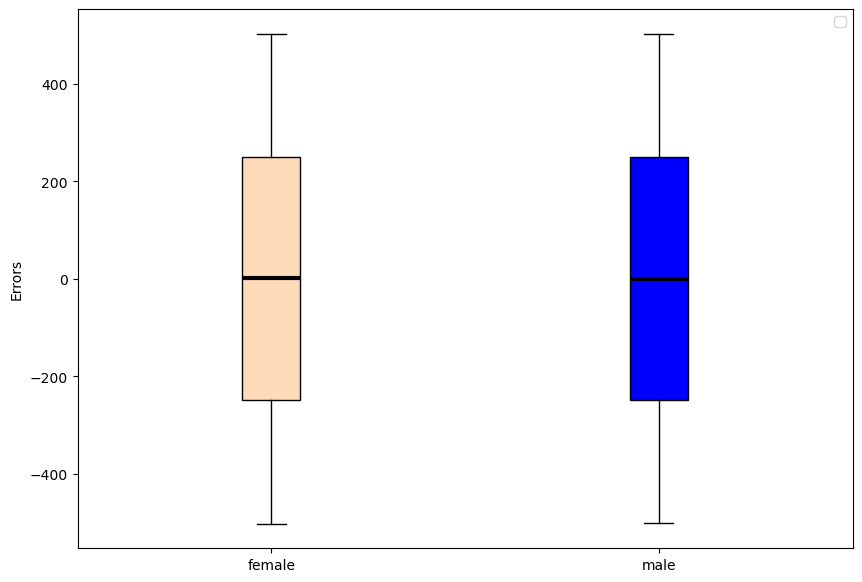

In [76]:
female = X_test[X_test['gender'] == 'female'].difference
male = X_test[X_test['gender'] == 'male'].difference

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [female, male]
bplot = ax.boxplot(data,
                   patch_artist=True)

ax.set_xticklabels(['female', 'male'])

for patch, color in zip(bplot['boxes'], ['peachpuff', 'blue']):
    patch.set_facecolor(color)

for median in bplot['medians']:
    median.set(color ='black',
               linewidth = 3)

ax.set_ylabel('Errors')
ax.legend()
plt.show()

For our predictions with the test dataset, it seems that the errors are equal for male and female, further hinting that the true charges does take into account the gender of the customer. 

In [46]:
df = pd.read_csv('insurance_dataset.csv')
X = df.drop('charges', axis=1)

X.family_medical_history = X.family_medical_history.replace(np.nan, 'No history')
X.medical_history = X.medical_history.replace(np.nan, 'No history')
y = df['charges']

# Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30, random_state = 20)
X_train['charges'] = y_train
training = X_train.copy()

formula = 'charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)'
model = smf.ols(formula = formula, data = training).fit()

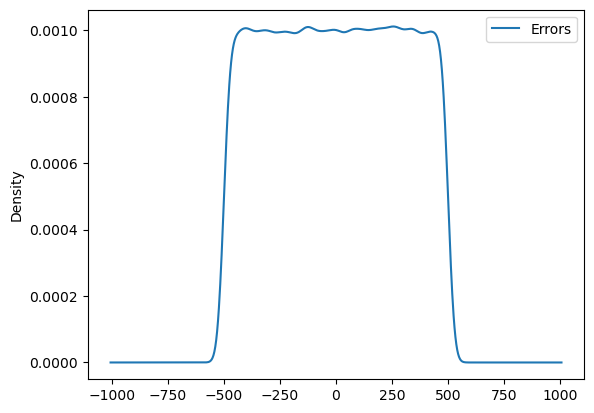

In [74]:
test_predictions = model.predict(X_test)
X_test['predictions'] = test_predictions
X_test['True Y'] = y_test
X_test['error'] = X_test['True Y'] - X_test.predictions
X_test.error.plot.density(label = 'Errors')

plt.legend()
plt.show()

Error terms seems to be uniformly distributed instead of normally. However, both uniform and gaussian model are symmetric, so even though the data is not really Gaussian, the line that best fit the data will be the same. 

A problem is that the coefficient estimators will not be t-distributed when using OLS becuase of unifromly distributed errors, so the associated p values will be unreliable.

In [67]:
df.charges.mean()

16735.117480593424

Text(0.5, 1.0, 'Residual plot')

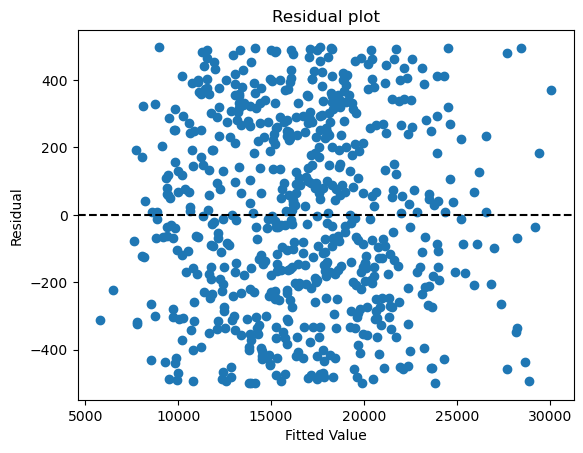

In [41]:
plt.scatter(X_test.predictions[:650], X_test.error[:650])
plt.axhline(0, 0,1, color = 'black', linestyle = '--')

plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual plot')